<a href="https://colab.research.google.com/github/saivenkatreddy29/Pytorch-Learning/blob/main/Replicating_papers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


In [2]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print('info: couldnt find torch info installing it')
  !pip install torchinfo
  from torchinfo import summary

try:
  from going_modular.going_modular import datasetup,engine
  from helper_functions import download_data,set_seeds, plot_loss_curves
except:
  print('info: couldnt find the helper functions downloading them')
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves


info: couldnt find torch info installing it
info: couldnt find the helper functions downloading them
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 4356 (delta 213), reused 253 (delta 177), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 32.36 MiB/s, done.
Resolving deltas: 100% (2584/2584), done.
Updating files: 100% (248/248), done.


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
image_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination = "pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path/'train'
test_dir = image_path/'test'

Create Datasets and DataLoaders

In [6]:
IMAGE_SIZE = 32

manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
]
)
print(f'Manually created transforms: {manual_transforms}')

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


Turn images to Dataloaders


In [7]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7bb7d0470df0>,
 ['pizza', 'steak', 'sushi'])

Visualize a Single Image

In [8]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [9]:
image_batch, label_batch = next(iter(train_dataloader))
image = image_batch[0]
label = label_batch[0]



In [10]:
print(image.shape)
per_image = image.permute(1,2,0)
print(per_image.shape)

torch.Size([3, 224, 224])
torch.Size([224, 224, 3])


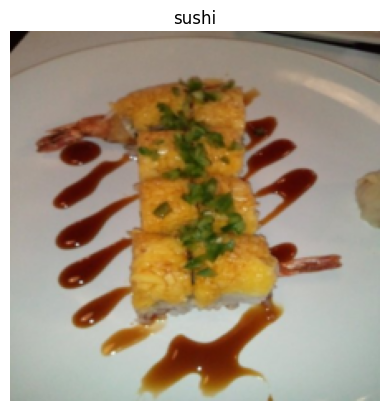

In [11]:
plt.imshow(per_image)
plt.title(class_names[label])
plt.axis('off');


Calculate path embedding input and output shapes

In [12]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = (height*width)//(patch_size*patch_size)
print(f'number of patches:{number_of_patches}, height and width of patch:{patch_size}')

number of patches:196, height and width of patch:16


In [13]:
embedding_layer_input_shape = (height,width,color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f'Input shape (single 2D image): {embedding_layer_input_shape}')
print(f'Output shape (single 2D flattened into patches):{embedding_layer_output_shape}')



Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D flattened into patches):(196, 768)


Turning Single image into patches

In [14]:
per_image.shape

torch.Size([224, 224, 3])

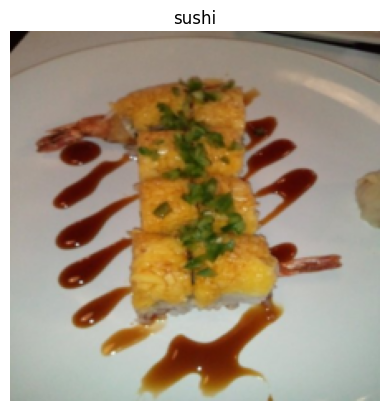

In [15]:
plt.imshow(per_image)
plt.title(class_names[label])
plt.axis(False);

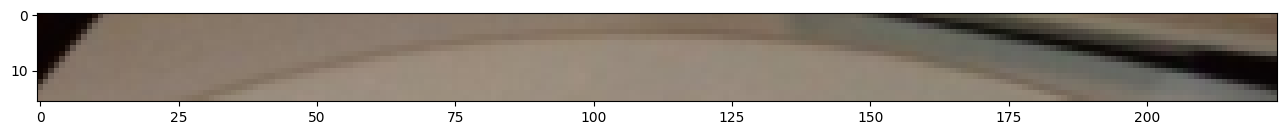

In [16]:
patch_size = 16
plt.figure(figsize = (patch_size,patch_size))
plt.imshow(per_image[:patch_size,:,:]);

Number of patches per row :14.0: patch dim:16


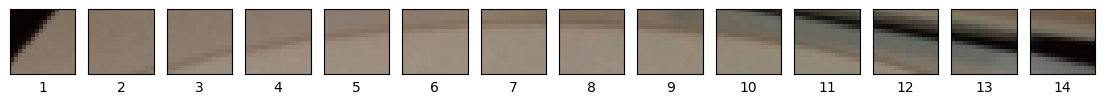

In [17]:
img_size = 224
patch_size =16
num_patches = img_size/patch_size
assert img_size%patch_size ==0, "image must be divisiblbe by patch size"
print(f"Number of patches per row :{num_patches}: patch dim:{patch_size}")

fig,axs = plt.subplots(nrows = 1,
                       ncols = img_size//patch_size,
                       figsize = (num_patches,num_patches),
                       sharex = True,
                       sharey = True
                       )

for i, patch in enumerate(range(0,img_size,patch_size)):
  axs[i].imshow(per_image[:patch_size,patch:patch+patch_size,:]);
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])


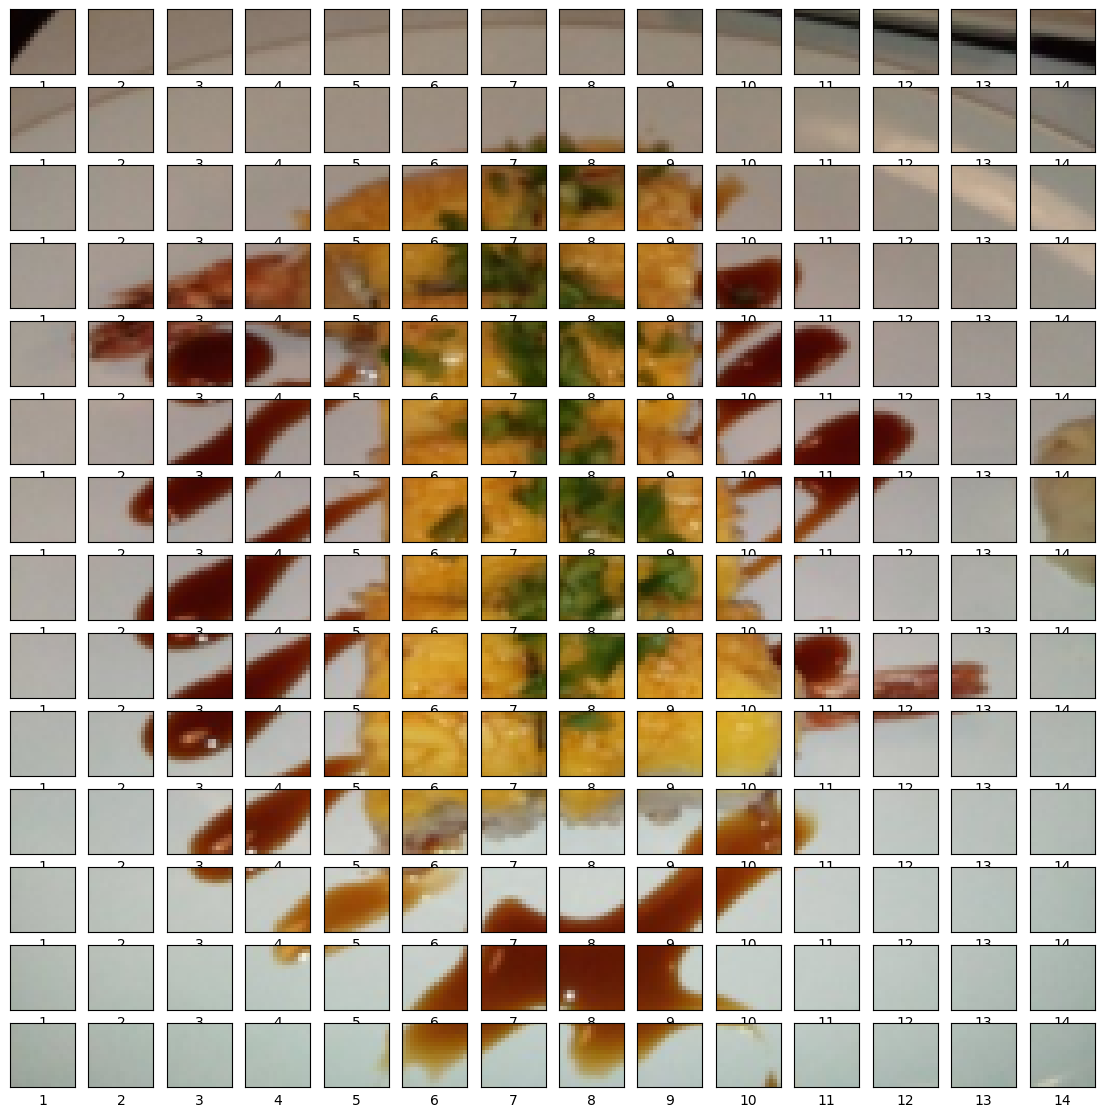

In [18]:
num_rows = img_size//patch_size
fig,axs = plt.subplots(nrows = num_rows,
                       ncols = img_size//patch_size,
                       figsize = (num_patches,num_patches),
                       sharex = True,
                       sharey = True
                       )
for j,patch_height in enumerate(range(0,img_size,patch_size)):
  for i, patch in enumerate(range(0,img_size,patch_size)):
    axs[j,i].imshow(per_image[patch_height:patch_height+patch_size,patch:patch+patch_size,:]);
    axs[j,i].set_xlabel(i+1)
    axs[j,i].set_xticks([])
    axs[j,i].set_yticks([])

Creating iamge patches using torch.Conv2d()

In [19]:
from torch import nn
patch_size = 16

conv2d = nn.Conv2d(
    in_channels = 3,
    out_channels = 768,
    stride = patch_size,
    kernel_size = patch_size
)

In [20]:
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

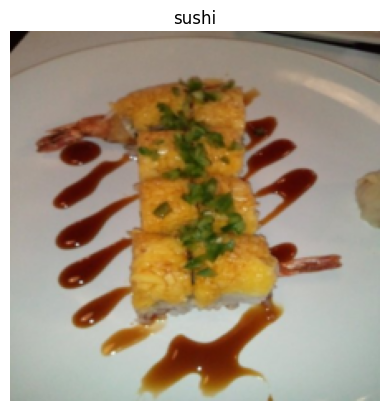

In [21]:
plt.imshow(per_image)
plt.title(class_names[label])
plt.axis(False);

In [22]:
print(image.shape)
image_out_of_conv = conv2d(image.unsqueeze(dim = 0))
print(image_out_of_conv.shape)

torch.Size([3, 224, 224])
torch.Size([1, 768, 14, 14])


showing random conv feature maps of indexes:[541, 659, 81, 346, 733]


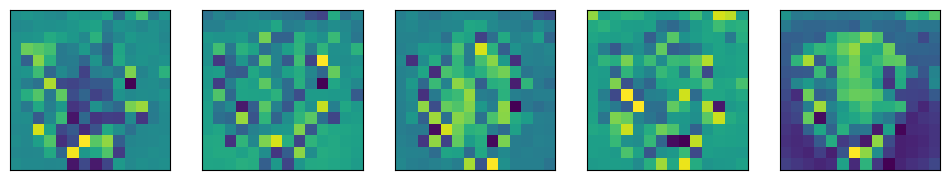

In [23]:
import random
random_indexes = random.sample(range(0,758),k=5)
print(f'showing random conv feature maps of indexes:{random_indexes}')

fig,axs = plt.subplots(nrows = 1,ncols = 5, figsize=(12,12))

for i,idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:,idx,:,:]
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels = [], yticklabels = [],xticks = [],yticks = []);

showing random conv feature maps of indexes:[749, 660, 594, 122, 10]


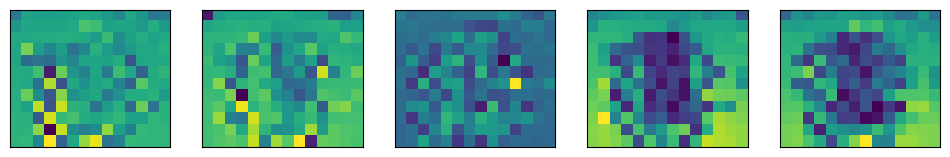

In [24]:
import random
random_indexes = random.sample(range(0,758),k=5)
print(f'showing random conv feature maps of indexes:{random_indexes}')

fig,axs = plt.subplots(nrows = 1,ncols = 5, figsize=(12,12))

for i,idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:,idx,:12,:]
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels = [], yticklabels = [],xticks = [],yticks = []);

In [25]:
single_feature_map = image_out_of_conv[:,0,:,:]
single_feature_map.shape,single_feature_map.requires_grad

(torch.Size([1, 14, 14]), True)

Flattening the path embedding with torch.nn.Flatten()

In [26]:
print(f'current tensor shape :{image_out_of_conv.shape}')

current tensor shape :torch.Size([1, 768, 14, 14])


In [27]:
flatten = nn.Flatten(start_dim =2,
                     end_dim = 3)

Original image shape:torch.Size([3, 224, 224])
image shape after conv is torch.Size([1, 768, 14, 14])
image after faltten is torch.Size([1, 768, 196])


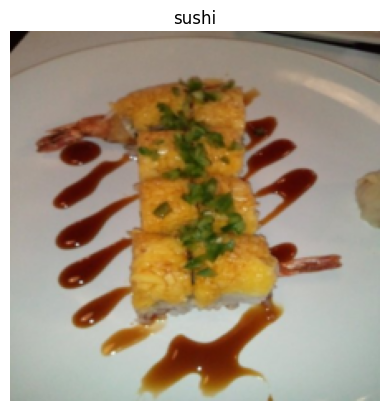

In [28]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);
print(f'Original image shape:{image.shape}')

image_out_of_conv = conv2d(image.unsqueeze(0))
print(f'image shape after conv is {image_out_of_conv.shape}')

image_flattened = flatten(image_out_of_conv)
print(f'image after faltten is {image_flattened.shape}')

In [29]:
image_out_of_conv_flattened_reshaped = image_flattened.permute(0,2,1)
print(f'Patch embedding sequence shape:{image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]')

Patch embedding sequence shape:torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


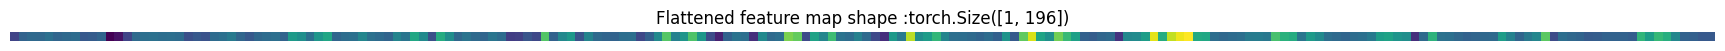

In [30]:
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:,:,0]

plt.figure(figsize = (22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape :{single_flattened_feature_map.shape}')
plt.axis(False);

Turning the VIT patch embedding layer into Pytorch module

In [35]:
class PatchEmbedding(nn.Module):
  def __init__(self):
    super().__init__()
    self.in_channels = 3
    self.patch_size = 16
    self.embedding_dim = 768
    self.conv2d = nn.Conv2d(
        in_channels = self.in_channels,
        out_channels = self.embedding_dim,
        kernel_size = self.patch_size,
        stride = self.patch_size
    )
    self.flatten = nn.Flatten(start_dim = 2,
                              end_dim = 3)
  def forward(self,x):
    assert x.shape[-1] % self.patch_size == 0, f'Input size must be divisibel by patch size image:{x.shape} and patch:{self.patch_size}'
    x = self.conv2d(x)
    print(x.shape)

    x = self.flatten(x)
    return x.permute(0,2,1)


In [36]:
embedding = PatchEmbedding()
flatten_output = embedding(image.unsqueeze(0))
print(flatten_output.shape)

torch.Size([1, 768, 14, 14])
torch.Size([1, 196, 768])
